# CS110 Final Project

## Question 1 - Maximum Profit Scheduler

The problem of finding an optimal scheduler here has 3 constraints: 
 * The schedule has to be within the a timespan that lies between the start time of the earliest activity and the end time of the last activity. 
 * No activity can start before its start time
 * Activities cannot overlap

Therefore, we can create an activity scheduler that takes the activities in a sorted way that shows when they are done and also what the last possible activity before it is. By doing so we can compare we can exploit the optimal substructure of the problem.
Optimal substructure exists because including an activity will either increase the profit or not (it is a binary choice) and is dependent on which activities are excluded by it being added or not. That is we exclude all activities that occur after the "parent" activity which is the activity with the finish time closest to the start time of the activity. That is what is the last activity that can be done should the current activity be chosen. All activities that have finish times between this parent activity and the start of the current job cannot be chosen anymore. 

Hence, a recursion can be built for the selection of an activity a out of a list of activities that are sorted by their finishing times and a is the index of the activity in that sorted list: 

* SELECT(a):
    * cannot select activities that between Parent(a) and Finish(a)
    * The jobs prior to Parent(a) must be an optimal solution to the problem of selecting Parent(a).

* DON'T SELECT(a):
    * The activities that could be included between Parent(a) and Finish(a) have a higher profit than when we include a and their profit is therefore the optimal solution to a. 

$ Select(a) 

* $ = 0$  if a = 0.
* $=  max(select(Parent(a) + a.Profit, select(a - 1))$

Using a brute force algorithm we can build this recursion. 

Practically, we can create an activity class, that takes as its an activities start, duration, and profit. Using a function to find the parent index we can fill in an attribute for each parent. 

For an example let us take an input that looks something like Fig. 1. We can draw a  tree (Fig. 2) to represent the 4 different possible schedules which are possible in this scenario. M represents a misnomer activity that starts at 0, ends at 0 and has 0 profit. It exists to end the recursion. Note that in each case we also calculate the profit between of M so that we can find the profit of A and B. Notice how we compute the comparison between D and C also twice because we compare it on whether we choose A or B. That is when we start at the highest integer in our recursion (here activity D), we compare its profit to that which would be possible if we had choosen C instead twice once with A and once with B. However, if we made use of the overlapping subproblem which is the optimal choice is first between A and B we can make just two choices: once between A and B and once between C and D. 

Our recursion seems to work on our simple example as it outputs a total profit of 9 which is the maximum we would expect after drawing out the tree. 



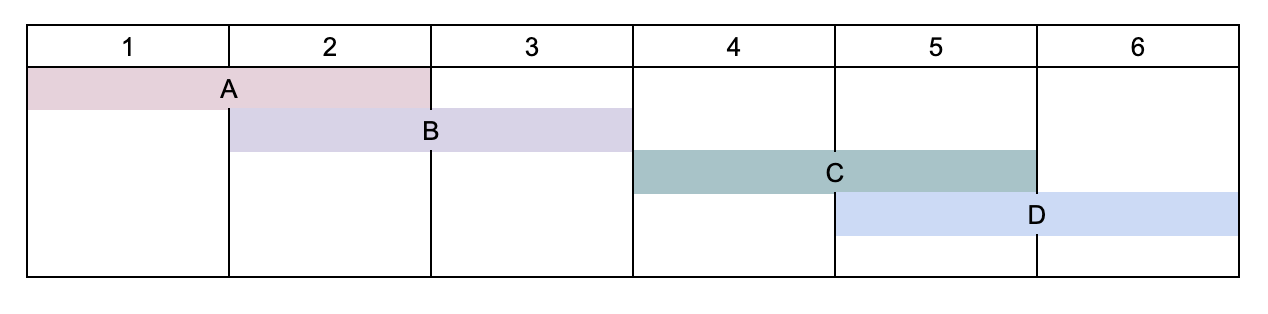
					

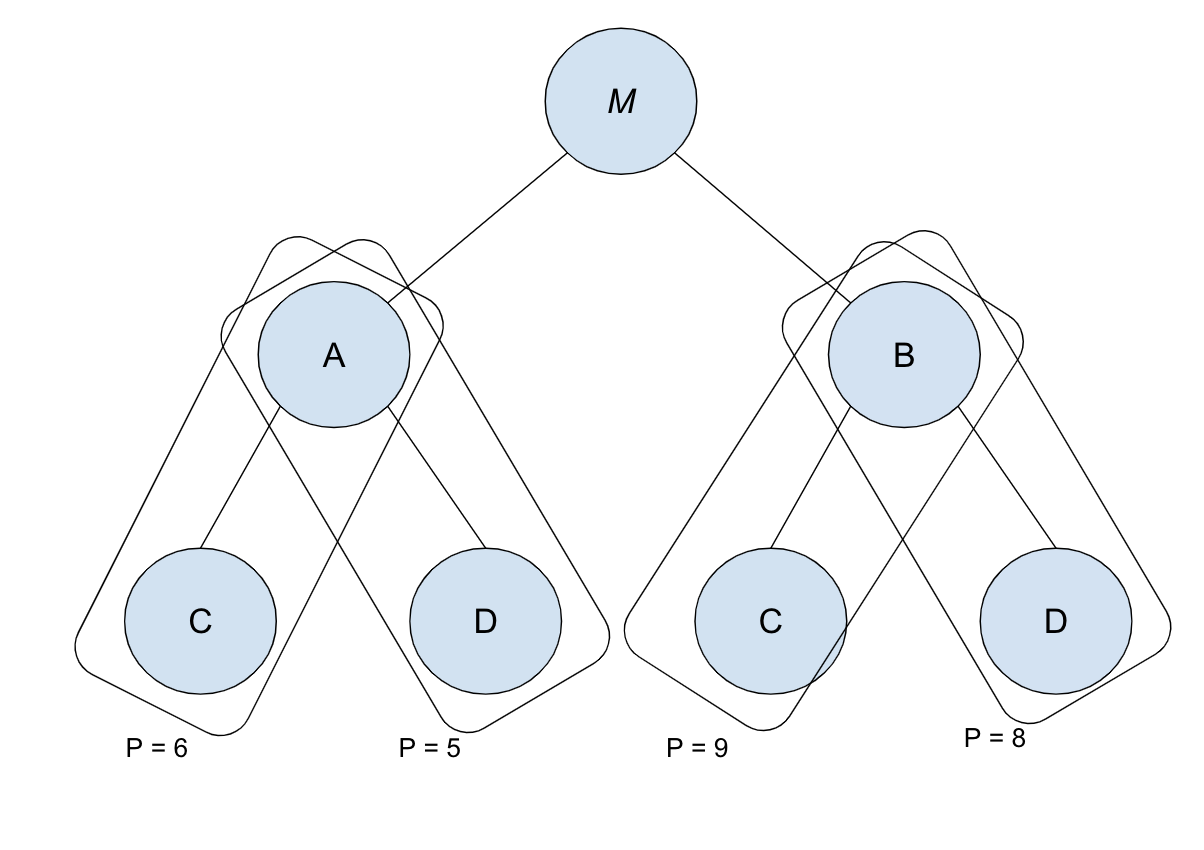

In [0]:
import numpy as np
import math

class Activity():

    """
    Class: Activity
    Initialize the activity class. 
    Each activity has a name, a length, a unit of length and a profit. 
    """

    #init method to initialize the class
    def __init__(self, name, start, length, profit):
        self.name = name
        self.start = start
        self.length = length
        self.end = start + length
        self.profit = profit
        self.parent = 0


In [2]:
#Specific an easy to work with input. 
#Each activity in the activity list is ordered by [name, start, duration, profit]
activities_raw = [('A', 0, 2, 2), 
              ('B', 1, 2, 5),
              ('C', 3, 2, 4), 
              ('D', 4, 2, 3)]


def find_parent(act_list, ind_a):

    """
    func: find_parent
    Inputs: - the list of activities which are objects of class Activity
            - the index of the current activity in the list

    Outputs: The index of the parent in the list

    Iterates through the activities coming before the current activity.
    Stops when it finds the parent.
    """

    #for every task before the activity
    for p_in in range(ind_a, 0, -1):
        
        #if the suggested parent has ends before the current act starts
        if act_list[p_in].end <= act_list[ind_a].start:
            #return the index of the suggested parent
            return p_in
    
    #if there is no activity ending earlier, make the parent the misnomer
    else: return 0

def create_objects(activities_raw):

    """
    func: create_objects
    Input:  - Takes a raw list of activities formatted as [name, start, duration, profit]
    Outputs:- A list of Activity objects, sorted by end with assigned parents

    Creates objects out of the raw input, 
    Sorts them by finish time, 
    Finds each activity a parent.
    """

    #make a activity_oject list
    activities = []
    for a in activities_raw:
        act = a
        activities.append(Activity(a[0], a[1], a[2], a[3]))

    #add a misnomer activity as the root. This will be the stopage criteria
    activities.insert(0, Activity('Misnomer', 0, 0, 0))

    #sort the activities in order.
    activities.sort(key = lambda x: x.end)

    #find the parent of each node
    for i in range(len(activities)):
        activities[i].parent = find_parent(activities, i)

    #print(f'parents: {[(a.name, a.parent) for a in activities]}')

    return activities

print([a.end for a in create_objects(activities_raw)])


[0, 2, 3, 5, 6]


In [3]:
import pandas as pd

tab_simple = pd.DataFrame(activities_raw, columns=['Name','Start', 'Duration', 'Profit'])
tab_simple

,Name,Start,Duration,Profit
0,A,0,2,2
1,B,1,2,5
2,C,3,2,4
3,D,4,2,3


In [4]:
def brute_force_schedule(acts, index):

    """
    func    brute_force_schedule
    Inputs: - The activities 
            - The current index
    Outputs:- The max of the recursion

    Uses the recursion to solve the optimal activity scheduling. 
    """

    #base case: we have reached the misnomer in the list indexed at 0
    if index == 0:
        #return 0 profit
        return 0
        
    #until we reach the base case:
    else:
        #return the maximum profits
        return max(acts[index].profit + brute_force_schedule(acts, acts[index].parent), brute_force_schedule(acts, index - 1))


#convert the list-type activities into objects
activities = create_objects(activities_raw)

brute_force_schedule(activities, len(activities) -1)

9

Figure 2 is a great illustration of how the brute force algorithm solves subproblems multiple times. We can also recognize that this means that we can optimize our approach, by using a memoization in dynamic programming. This way we can store our solution to previous choices made such as whether to choose A or B in our simple example to then choose C or D.

We can hence, build a table that for every activity we have includes the maximum profit up to that point which we can simply retrieve every time we would usually solve the entire problem again. 

In [0]:
def trace_back(acts, mem):

    """
    func: trace_back
    Input:  - finished memoization table
    Output: - Schedule

    Going backwards, we check if an activity was added or not.
    If it was added add it to the schedule and move on to the parent.
    """

    #initialize the schedule
    schedule = []

    #start with the last activity
    i = len(mem) - 1

    #until we reach the last activity
    while i > 0:
        
        #check if that activity increased profit
        if mem[i] > mem[i - 1]:

            #if yes, add it to the schedule
            schedule.insert(0, acts[i].name)
            #move on to the parent
            i = acts[i].parent

        #move on to the previous activity
        else:
            i -= 1
    #return the schedule
    return schedule


In [0]:
def DP_Schedule(acts_raw):

    """
    func: DP_Schedule
    Inputs: - Takes a list of activities with format: ['name',start, length, profit]
    Outputs:- The maximum profit

    Calls on function create object to create a sorted list of objects that include parents.
    Stores the max profit possible from every activity that is either included or not included.
    """

    #create objects, sort, assign parents.
    acts = create_objects(acts_raw)

    #initialize table
    memoize_table = np.zeros(len(acts))

    #for all activities
    for index in range(1, len(acts)):

        #update the profit table 
        #by taking the maximum of either the current activity's profit and it's parent's profit (which we have already computed)
        #and compare it to not choosing the activity
        memoize_table[index] = max(acts[index].profit + memoize_table[acts[index].parent], memoize_table[index-1])

    #get the schedule
    s = trace_back(acts, memoize_table)

    #return the final maximum profit
    return s, memoize_table[-1]

In [7]:
DP_Schedule(activities_raw)

(['B', 'C'], 9.0)

In [8]:
import random as rd
stacked_activities = [['a', 1, 2, 5],
                      ['b', 1, 2, 5],
                      ['c', 3, 2, 5],
                      ['d', 3, 2, 5]]

for _ in range(4):
    rd.seed(_)
    rd.shuffle(stacked_activities)
    print(stacked_activities)
    print(DP_Schedule(stacked_activities))

[['c', 3, 2, 5], ['a', 1, 2, 5], ['b', 1, 2, 5], ['d', 3, 2, 5]]
(['a', 'c'], 10.0)
[['d', 3, 2, 5], ['c', 3, 2, 5], ['b', 1, 2, 5], ['a', 1, 2, 5]]
(['b', 'd'], 10.0)
[['c', 3, 2, 5], ['b', 1, 2, 5], ['a', 1, 2, 5], ['d', 3, 2, 5]]
(['b', 'c'], 10.0)
[['d', 3, 2, 5], ['c', 3, 2, 5], ['a', 1, 2, 5], ['b', 1, 2, 5]]
(['a', 'd'], 10.0)


### Complexity Analysis

The dynamic programming solution is much more efficient in space and time than the recursive brute force approach. 
The brute force approach has to save the maximum profit in each recursion call. That means it saves the results while running the recursion. The memoization instead takes stores these values in one table with space $O(n)$ and simply accesses them when needed without having to carry them over in each recursion. 

Similarly the time complexity of the dynamic programming is much quicker because for each activity in the list we just have to make one call which is the maximum between two values. Therefore, the main loop in the memoization approach just takes $O(n)$ where n is the number of activities. This applies in all cases. Further, when in the worst case, all activities are parents or no activity is added, the complexity of the trace_back function is $O(n)$ because we have to make a comparison at every activity. 

The brute force makes recursive calls that grow with the time that the tree increases. In the worst case, activities are stacked in a way that every node that is added contributes its index number of calls to the recursion and hence the complexity grows with the Fibonacci sequence ($O(\sum_{a = 1}^{a = n}{a})$) where n is the number of activities. 

Both algorithms have to sort through the activities first which takes $O(n log n)$ when using the built-in sort function. 


### Computational Critique

A key strength of the DP scheduler is its O(n) complexity in both space and time. 

Another advantage, is that the class minimize the space that is used and allows for easier accessing of objects without having to carry over lists of lists taht just take up space. The python objects are more efficient. 

However, both algorithms are dependent on the right input format to create the objects. While, we could include necessary checks or reminders to the user of which input format is required, this would take up unnecessary overhead. 

Further, the algorithm is input dependent when there are multiple optimal solutions. Consider a case where we have 4 activities of which all have the same profit and two have the same start and end time, with the other two having the same start and end time. Such as shown below. In this scenario the proift is always 10 but there are again 4 different solutions to the problem. To avoid this, we could shuffle the inputs. However, this algorithm will choose not to do that since the payoff is just the same max profit but the cost is an additional overhead from shuffling. Since, the input order does not matter for the maximum profit but just the activities we do, it fulfills its purpose regardless. If we cared a lot about an activity being included we have two options: implicitely add "utility" as profit OR add a secondary choice criteria for when there is a conflict. The earlier is less complicated, the latter would make the choice more explicit. Henceforth, I am making the assumption, that profit = utility. Therefore, the profit attribute is an aggregate measure of how important a activity is. 

Further, there is unnecessary space being used when we include the misnomer. The misnomer is important for both the recursion and the DP algorithm to work but it really does not carry any useable information. An implementation that does not need to use a misnomer would therefore, be preferable. 

# Part 2 - Testing the LBA Scheduler

In my LBA Part 1, I used two different chunking techniques to deal with multitasking tasks (MT). As discussed there using the greatest commond divisor rather than random chunk time was more efficient in both finish time and run time. Hence, I from here onwards I wil, be using that approach for chunking MT. 

In that assignment there were two big weaknesses that I identified: 
- The Real Life applicability
- Using the left over time in chunking. 

### Real life applicability

The algorithm I wrote from the LBA had some strange choices of multitasks being paired with one another. Such as "Discussing music" and "Having deep thoughts," which are both activities that require active thinking. 

In my LBA I wrote: 
"...in a more ideal algorithm, there would be a new column that includes tasks that are non-pairable/pairable with the task at hand." 

For sake of generalizability, it would be more efficient to include the type of activity that is being done: That is physical, cognitive, and interactive. We can do physical and cognitive, or physical and interactive tasks together. Two tasks of the same type or cognitive and interactive tasks are excluded from being done together. This not only improves the real life applicability of the scheduler but does so in a generalizable way. It means we can extend our priority function to include the type of activity when there is a multitask because to maximize the number of multitasking that goes on we should select cognitive and interactive tasks first for our multitasking. 

### Using the left over time in chunking

Currently when two tasks of varying length are chosen and they have a large common divider, the shorter task will be done in few chunks while the left over task will be done "alone" after. Sensing a room for optimization we can have a new, third task enter the field that gets executed until the other left over task is done. This idea brings with it two decisions: Do we continue with the thrid task and find a new one, should the left-over task be done? and in the other case: if the thrid task is also done should we add a fourth task?
The answer is "No" in both cases because in the first case, we would be getting ourselves into a spiral of adding more and more tasks every time a left over task is done and suddenly multitasking would dominate the task selection criteria even more. The same holds true for the second case, even though an argument can be made that if the thrid task selected is also short, there is again a lot of "unused" multitasking potential. Doing so would relegate the selection of multitasking to a Fractional Knapsack problem in which the longest possible multitask's length is the capacity and we just partially fill up the time.

### Advantage of multitasking

Currently, there is no advantage of multitasking on the total time the algorithm takes. Two MT with time 20 min and 40 min will still take 60 minutes to complete when pooled together. In the original scheduler this was justified by our brain in real life also switching back and forward between tasks, but an argument can be made that these MT still reduce the overall time. If I for example bike and listen to a podcast, I still take the same time to bike from A to B. This is true for any pairing of the possible multitasking pairs. 
Hence, I a future scheduler should "reward" the time I spend multitasking a task. This would make chunking somewhat irrelevant because we could just get the left over time by subtracting the lengths of the tasks. 

## Next steps

- The most important piece of improvement is that I include an benefit to multitasking. 

## Part 3 An improved scheduler

### Carrying over the code from the original scheduler. 

Notice, how there are 5 activities each denoted by double digits, and a group of stand alone tasks that will be included when the algorithm deems it most suitable. 

The LBA scheduler only has a single start time designated. That means that given a specific starting time, and a lists of tasks to execute, we receive a finish time for the entire scheduler. Notice here how the activities do not have an actual start time but are executed immedeatly after the previous task is finished. To make the analysis of the scheduler a worthwile problem, each activity block should have a start time which can then be fed to LBA scheduler. 

The LBA scheduler will take a list of tasks that are part of a set block of activities, and determine their finish time, which it can then assign to the activity. 
After doing this for all activities, we can use the assigned start, length, and a predetermined profit of the activity to then choose which activities are being choosen in our utility maximizing schedule. 

This will require some further patching. The task scheduler now takes also takes the start time of an activity as an input. Further, we return the total duration of an activity. 

In [0]:
## A day in the life ## 

Tasks = [[4, "Listening to NPR Podcast", 20, True, [], "NYS",[]],
 [5, "Having deep thoughts about the life of a Minervan", 5, True, [4],"NYS",[]],
 [6, "Bumping into friend from primary school", 1, True, [13,12,11], "NYS",[]],
 [7, "Discussing Bundesliga (German Football)", 10, True, [6, 13,12,11], "NYS",[]],
 [8, "(Internally) complaining about the weather (It is an LBA about Germany...)", 20, True, [4,5], "NYS", []],
 [9, "Biking Home", 30, True, [4,5,6,7,8,11,12,13,14,21,22,23,24,31,32,33,41,42,43,44,51,52,53], "NYS", []],
 
 [11, "Riding bike to Prenzlauer Berg", 15, True, [], "NYS",[]],
 [12, "Having brunch at Zuckerfee-Café", 60, False, [11], "NYS",[]],
 [13, "Paying", 2, False, [12,11], "NYS",[]],
 [14, "Discussing the music", 10, True, [11], "NYS", []],
 
 [21, "Walking to Mauerpark", 10, True, [14,13,12,11], "NYS",[]],
 [22, "Looking at vendors on street 1", 20, True, [21,14,13,12,11], "NYS",[]],
 [23, "Deciding not to buy anything", 1, True, [22,21,14,13,12,11], "NYS",[]],
 [24, "Changing mind and buy Korean street food", 5, False, [23,22,21,14,13,12,11], "NYS",[]],
 
 [31, "Going to a thriftstore", 18, True, [14,13,12,11],"NYS",[]],
 [32, "Selecting item of clothing", 20, True, [31, 14,13,12,11], "NYS", []],
 [33, "Thinking about movie to watch", 20, True, [31,14,13,12,11], "NYS", []],
 
 [41, "Contemplating Lunch choices", 3, True, [14,13,12,11], "NYS", []],
 [42, "Getting on U-Bahn", 1, False, [41,14,13,12,11], "NYS", []],
 [43, "Getting off U-Bahn", 14, False,  [42,41,14,13,12,11], "NYS", []],
 [44, "Looking at U-Bahn Weinmeisterstrasse",1,False, [43,42,41,14,13,12,11], "NYS", []],
 
 [51, "Ordering Burrito at Dolores Burritos", 15, False, [44, 43,42,41,14,13,12,11], "NYS", []],
 [52, "Eating Burrito", 20, True, [51,44,43,42,41,14,13,12,11], "NYS",[]],
 [53, "Walking back to Bike", 20, True, [51, 52, 44, 43,42,41,14,13,12,11], "NYS", []]]


In [10]:
import pandas as pd

tabul = pd.DataFrame(Tasks, columns = ['ID', 'Name', 'Length', 'Multitask?','Dependencies', 'Status', 'Priority Score'])
tabul

,ID,Name,Length,Multitask?,Dependencies,Status,Priority Score
0,4,Listening to NPR Podcast,20,True,[],NYS,[]
1,5,Having deep thoughts about the life of a Minervan,5,True,[4],NYS,[]
2,6,Bumping into friend from primary school,1,True,"[13, 12, 11]",NYS,[]
3,7,Discussing Bundesliga (German Football),10,True,"[6, 13, 12, 11]",NYS,[]
4,8,(Internally) complaining about the weather (It...,20,True,"[4, 5]",NYS,[]
5,9,Biking Home,30,True,"[4, 5, 6, 7, 8, 11, 12, 13, 14, 21, 22, 23, 24...",NYS,[]
6,11,Riding bike to Prenzlauer Berg,15,True,[],NYS,[]
7,12,Having brunch at Zuckerfee-Café,60,False,[11],NYS,[]
8,13,Paying,2,False,"[12, 11]",NYS,[]
9,14,Discussing the music,10,True,[11],NYS,[]


In [0]:
##max heap for determining the next task

# 
# Defining some basic binary tree functions
#
def left(i):         # left(i): takes as input the array index of a parent node in the binary tree and 
    return 2*i + 1   #          returns the array index of its left child.

def right(i):        # right(i): takes as input the array index of a parent node in the binary tree and 
    return 2*i + 2   #           returns the array index of its right child.

def parent(i):       # parent(i): takes as input the array index of a node in the binary tree and
    return (i-1)//2  #            returns the array index of its parent


# Defining the Python class MaxHeapq to implement a max heap data structure.
# Every Object in this class has two attributes:
#           - heap : A Python list where key values in the max heap are stored
#           - heap_size: An integer counter of the number of keys present in the max heap
class MaxHeapq:
    """ 
    This class implements properties and methods that support a max priority queue data structure
    """  
    # Class initialization method. Use: heapq_var = MaxHeapq()
    def __init__(self):        
        self.heap       = []
        self.heap_size  = 0
        self.Done       = []

    # This method returns the highest key in the priority queue. 
    #   Use: key_var = heapq_var.max()
    def maxk(self):              
        return self.heap[0]     
    
    # This method implements the INSERT key into a priority queue operation
    #   Use: heapq_var.heappush(key)
    def heappush(self, key):   
        """
        Inserts the value of key onto the priority queue, maintaining the max heap invariant.
        """
        self.heap.append(-float("inf"))
        priority_function(key)
        self.increase_key(self.heap_size,key)
        self.heap_size+=1
        
    # This method implements the INCREASE_KEY operation, which modifies the value of a key
    # in the max priority queue with a higher value. 
    #   Use heapq_var.increase_key(i, new_key)
    def increase_key(self, i, key): 
        if key[6] < self.heap[i]:
            raise ValueError('new key is smaller than the current key')
        self.heap[i] = key
        while i > 0 and self.heap[parent(i)][6] < self.heap[i][6]:
            j = parent(i)
            holder = self.heap[j]
            self.heap[j] = self.heap[i]
            self.heap[i] = holder
            i = j    
            
    # This method implements the MAX_HEAPIFY operation for the max priority queue. The input is 
    # the array index of the root node of the subtree to be heapify.
    #   Use heapq_var.heapify(i)        
    def heapify(self, i):
        l = left(i)
        r = right(i)
        heap = self.heap
        if l <= (self.heap_size -1) and heap[l][6] > heap[i][6]:
            largest = l
        
        else:
            largest = i
            
        if r <= (self.heap_size -1) and heap[r][6] > heap[largest][6]:
            largest = r
        
        if largest != i:
            heap[i], heap[largest] = heap[largest], heap[i]
            self.heapify(largest)
            
    

    # This method implements the EXTRACT_MAX operation. It returns the largest key in 
    # the max priority queue and removes this key from the max priority queue.
    #   Use key_var = heapq_var.heappop() 
    def heappop(self, location):
        if self.heap_size < 1:
            raise ValueError('Heap underflow: There are no keys in the priority queue ')
        maxk = self.heap[location]
        self.heap[location] = self.heap[-1]
        self.heap.pop()
        self.heap_size-=1
        self.heapify(location)
        return maxk
    
    def overview(self):
        display = [(self.heap[i][0],self.heap[i][6], self.heap[i][3]) for i in range(len(self.heap))]

In [0]:
#find priority of each task
def priority_function(task):
    if type(task) == int:
        return task
    
    prio_value = 0
    
    #count number of dependencies
    for t in Tasks:
        
        if task[0] in t[4]:
            prio_value += 1
            
            
    #if task is multitasking we up it's priority (this makes the)   
    if task[3] == True:
        prio_value = 2*prio_value
    
    #add the task into an extra cell in the priority function
    task[6] = prio_value
    return prio_value

In [13]:
#Running the whole thing
def main(Tasks, start_time):

    """
    func: LBA Scheduler 
    Inputs: - A list of tasks in format: [Task-ID, "Task Name", Length, Is Multitask (Bool), [Dependencies], "Status",[empty space for priority score]]
            - Start time: In minutes since midnight.
    Outputs: Duration of all tasks in minutes

    Uses a max heap to find the next task to be executed based on an priority score. 
    The priority score is calculated using func: priority_function.
    Two multitasks are scheduled when possible and the length of the longer task will be how long both now take.
    """


    #random.shuffle(Tasks)
    pQ = MaxHeapq()
    
    def initialize(pQ):
        for task in Tasks:
            pQ.heappush(task[:])
        return pQ
            
    def find_next(start_index, multitask):
    
        #for each task in the queue
        for index in list(range(start_index, len(pQ.heap))):

            #get the entire task at the current index
            task = pQ.heap[index]
            
            if task[3] not in multitask:
                continue

            #check if dependencies are executed
            deps_done = 0

            #Check if the elemets in the dependencies
            for t in task[4]:

                #are in the list of done elements
                if t in pQ.Done:

                    deps_done += 1

            #dependencies done?
            if deps_done == len(task[4]):
                #if all dependencies are done, return that index and finish the for-loop
                return index
    
    #find the next task
    def execute_next(current_time):
    
        to_be_executed = find_next(0, [True, False])

        #update status
        pQ.heap[to_be_executed][5] = 'IP'

        #pop the task and maintain heap structure
        task_1 = pQ.heappop(to_be_executed)

        #if multitask
        if task_1[3] == True and len(pQ.heap) > 0:
            
            #Look for the next multitask after the current multi-task. All before that could not be executed.
            multi = find_next(to_be_executed, [True])
    
            #should there be no other multitask
            if multi is None:
                pQ.Done.append(task_1[0])
                task_1[5] = "Completed"
                current_time += task_1[2]
                print(f"Finished {task_1[1]} after {task_1[2]} minutes")
                return current_time

            #update status
            pQ.heap[multi][5] = 'IP'

            task_2 = pQ.heappop(multi)

            #use the math.gcd() function to find the greatest common divisor of their times
            divider = math.gcd(task_1[2],task_2[2])
            print(f"Tasks are partitioned into chunks of {divider} minutes")
            #record the time it takes for tasks to be done
            time_to_execute = 0

            #do tasks
            while task_1[2] > 0 or task_2[2] > 0:

                #if neither task is done do both
                if task_1[2] > 0 and task_2[2] > 0:

                    task_1[2] -= divider
                    task_2[2] -= divider

                    print(f"Executing: {task_1[1]} with remaining time {task_1[2]}")
                    print(f"Executing: {task_2[1]} with remaining time {task_2[2]}")

                    #Patching here: The divider is how I am counting the time the tasks take
                    #to execute. The original code multiplied this divider by 2: time_to_execute += divider*2
                    #To "reward" multitasking and a good divider, we will only add it once.
                    time_to_execute += divider

                #finish the uncompleted task
                elif task_1[2] > 0 and task_2[2] <= 0:

                    #the time to execute is the remaining time. This stays the same
                    time_to_execute += task_1[2]
                    task_1[2] -= task_1[2]


                else:
                    #the time to execute is the remaining time. This stays the same
                    time_to_execute += task_2[2]
                    task_2[2] -= task_2[2]


            #Proclaim the success of finishing the tasks
            pQ.Done.append(task_1[0])
            pQ.Done.append(task_2[0])
            print(f"Finished {task_1[1]} and {task_2[1]} after {time_to_execute} minutes")

            current_time += time_to_execute
            return current_time

        else:
            pQ.Done.append(task_1[0])
            task_1[5] = "Completed"
            current_time += task_1[2]
            print(f"Finished {task_1[1]} after {task_1[2]} minutes")
            return current_time       
            
    #create pQ as part of the class
    initialize(pQ)


    #The main function now includes an additional input which is the start time
    #This let's us output an actual time total of when and how the tasks where executed.
    current_time = start_time

    while len(pQ.Done) != len(Tasks):
        current_time = execute_next(current_time)

        print(f"The current time is {math.floor(current_time/60)}:{current_time%60}")

    return current_time - start_time
        
main(Tasks, 540)

Tasks are partitioned into chunks of 5 minutes
Executing: Riding bike to Prenzlauer Berg with remaining time 10
Executing: Listening to NPR Podcast with remaining time 15
Executing: Riding bike to Prenzlauer Berg with remaining time 5
Executing: Listening to NPR Podcast with remaining time 10
Executing: Riding bike to Prenzlauer Berg with remaining time 0
Executing: Listening to NPR Podcast with remaining time 5
Finished Riding bike to Prenzlauer Berg and Listening to NPR Podcast after 20 minutes
The current time is 9:20
Tasks are partitioned into chunks of 5 minutes
Executing: Discussing the music with remaining time 5
Executing: Having deep thoughts about the life of a Minervan with remaining time 0
Finished Discussing the music and Having deep thoughts about the life of a Minervan after 10 minutes
The current time is 9:30
Finished Having brunch at Zuckerfee-Café after 60 minutes
The current time is 10:30
Finished Paying after 2 minutes
The current time is 10:32
Tasks are partitioned

268

## Integration of both schedulers

To integrate the two schedulers, we have to seperate the activities slighlty into actually lists, assign them name, profit, and start time. This allows us to treat them as an actual activity block. I will use the activity blocks that I specified using the codes in the LBA. The free floating activities will be added into the buckets of tasks they were assigned to by the original scheduler. By chunking the activities into more groups, a big practicality issue of the first scheduler can be resolved. That, we do not have to keep track of all the different dependencies apply for one task across all activities because they will run separate regardless. By assigning a task to an activity with start time later than tasks that were previously listed as dependent, can now be excluded from the dependency list.


In [0]:
Activity_blocks = [['Getting Brunch at Prenzlauer Berg', 
                    600,
                    20,
 [[11, "Riding bike to Prenzlauer Berg", 15, True, [], "NYS",[]],
 [4, "Listening to NPR Podcast", 20, True, [], "NYS",[]],
 [12, "Having brunch at Zuckerfee-Café", 60, False, [11], "NYS",[]],
 [13, "Paying", 2, False, [12,11], "NYS",[]],
 [14, "Discussing the music", 10, True, [11], "NYS", []],
 [5, "Having deep thoughts about the life of a Minervan", 5, True, [4],"NYS",[]]]],
 
 ['Visiting Mauerpark', 
  720, 
  12,
  [[21, "Walking to Mauerpark", 10, True, [], "NYS",[]],
 [22, "Looking at vendors on street 1", 20, True, [21], "NYS",[]],
 [23, "Deciding not to buy anything", 1, True, [22,21], "NYS",[]],
 [24, "Changing mind and buy Korean street food", 5, False, [23,22,21], "NYS",[]],
 [6, "Bumping into friend from primary school", 1, True, [], "NYS",[]],
 [7, "Discussing Bundesliga (German Football)", 10, True, [6], "NYS",[]]]],
 
 ['Thrifting',
  720,
  13,
  [[31, "Going to a thriftstore", 18, True, [],"NYS",[]],
 [32, "Selecting item of clothing", 20, True, [31], "NYS", []],
 [33, "Thinking about movie to watch", 20, True, [31], "NYS", []],
 [8, "(Internally) complaining about the weather (It is an LBA about Germany...)", 20, True, [], "NYS", []]]],
 
 ['Travelling to Lunch',
  781,
  10,
  [[41, "Contemplating Lunch choices", 3, True, [], "NYS", []],
 [42, "Getting on U-Bahn", 1, False, [41], "NYS", []],
 [43, "Getting off U-Bahn", 14, False,  [42,41], "NYS", []],
 [44, "Looking at U-Bahn Weinmeisterstrasse",1, True, [43,42], "NYS", []]]],
 
 ['Getting lunch and going Home',
  820,
  20,
  [[51, "Ordering Burrito at Dolores Burritos", 15, False, [], "NYS", []],
 [52, "Eating Burrito", 20, True, [51], "NYS",[]],
 [53, "Walking back to Bike", 20, True, [51], "NYS", []],
 [9, "Biking Home", 30, True, [51,52,53], "NYS", []]]]]

In [15]:
Blocked = pd.DataFrame(Activity_blocks, columns= ['Name', 'Time','Utility', 'Tasks'])
pd.set_option('display.max_colwidth', -1)
Blocked.head(5)

,Name,Time,Utility,Tasks
0,Getting Brunch at Prenzlauer Berg,600,20,"[[11, Riding bike to Prenzlauer Berg, 15, True, [], NYS, []], [4, Listening to NPR Podcast, 20, True, [], NYS, []], [12, Having brunch at Zuckerfee-Café, 60, False, [11], NYS, []], [13, Paying, 2, False, [12, 11], NYS, []], [14, Discussing the music, 10, True, [11], NYS, []], [5, Having deep thoughts about the life of a Minervan, 5, True, [4], NYS, []]]"
1,Visiting Mauerpark,720,12,"[[21, Walking to Mauerpark, 10, True, [], NYS, []], [22, Looking at vendors on street 1, 20, True, [21], NYS, []], [23, Deciding not to buy anything, 1, True, [22, 21], NYS, []], [24, Changing mind and buy Korean street food, 5, False, [23, 22, 21], NYS, []], [6, Bumping into friend from primary school, 1, True, [], NYS, []], [7, Discussing Bundesliga (German Football), 10, True, [6], NYS, []]]"
2,Thrifting,720,13,"[[31, Going to a thriftstore, 18, True, [], NYS, []], [32, Selecting item of clothing, 20, True, [31], NYS, []], [33, Thinking about movie to watch, 20, True, [31], NYS, []], [8, (Internally) complaining about the weather (It is an LBA about Germany...), 20, True, [], NYS, []]]"
3,Travelling to Lunch,781,10,"[[41, Contemplating Lunch choices, 3, True, [], NYS, []], [42, Getting on U-Bahn, 1, False, [41], NYS, []], [43, Getting off U-Bahn, 14, False, [42, 41], NYS, []], [44, Looking at U-Bahn Weinmeisterstrasse, 1, True, [43, 42], NYS, []]]"
4,Getting lunch and going Home,820,20,"[[51, Ordering Burrito at Dolores Burritos, 15, False, [], NYS, []], [52, Eating Burrito, 20, True, [51], NYS, []], [53, Walking back to Bike, 20, True, [51], NYS, []], [9, Biking Home, 30, True, [51, 52, 53], NYS, []]]"


#### Designing the integrated scheduler

The scheduler needs to:
1. Take the acitivities
2. Compute their length
    
    a. Run through the LBA-Scheduler
    
    b. Create Activity object with the relevant details
3. Find the optimal schedule using the activity objects
4. Iterate over entire schedule to produce the final schedule of the day. 

In [16]:
#Running the whole thing
def main_silent(Tasks, start_time):

    """
    func: LBA Scheduler Silent
    Inputs: - A list of tasks in format: [Task-ID, "Task Name", Length, Is Multitask (Bool), [Dependencies], "Status",[empty space for priority score]]
            - Start time: In minutes since midnight.
    Outputs: Duration of all tasks in minutes

    Does exactly the same thing as the LBA-Scheduler but does so without printing any output
    """


    #random.shuffle(Tasks)
    pQ = MaxHeapq()
    
    def initialize(pQ):
        for task in Tasks:
            pQ.heappush(task[:])
        return pQ
            
    def find_next(start_index, multitask):
    
        #for each task in the queue
        for index in list(range(start_index, len(pQ.heap))):

            #get the entire task at the current index
            task = pQ.heap[index]
            
            if task[3] not in multitask:
                continue

            #check if dependencies are executed
            deps_done = 0

            #Check if the elemets in the dependencies
            for t in task[4]:

                #are in the list of done elements
                if t in pQ.Done:

                    deps_done += 1

            #dependencies done?
            if deps_done == len(task[4]):
                #if all dependencies are done, return that index and finish the for-loop
                return index
    
    #find the next task
    def execute_next(current_time):
    
        to_be_executed = find_next(0, [True, False])

        #update status
        pQ.heap[to_be_executed][5] = 'IP'

        #pop the task and maintain heap structure
        task_1 = pQ.heappop(to_be_executed)

        #if multitask
        if task_1[3] == True and len(pQ.heap) > 0:
            
            #Look for the next multitask after the current multi-task. All before that could not be executed.
            multi = find_next(to_be_executed, [True])
    
            #should there be no other multitask
            if multi is None:
                pQ.Done.append(task_1[0])
                task_1[5] = "Completed"
                current_time += task_1[2]
                return current_time

            #update status
            pQ.heap[multi][5] = 'IP'

            task_2 = pQ.heappop(multi)

            #use the math.gcd() function to find the greatest common divisor of their times
            divider = math.gcd(task_1[2],task_2[2])
            #record the time it takes for tasks to be done
            time_to_execute = 0

            #do tasks
            while task_1[2] > 0 or task_2[2] > 0:

                #if neither task is done do both
                if task_1[2] > 0 and task_2[2] > 0:

                    task_1[2] -= divider
                    task_2[2] -= divider
                    #Patching here: The divider is how I am counting the time the tasks take
                    #to execute. The original code multiplied this divider by 2: time_to_execute += divider*2
                    #To "reward" multitasking and a good divider, we will only add it once.
                    time_to_execute += divider

                #finish the uncompleted task
                elif task_1[2] > 0 and task_2[2] <= 0:

                    #the time to execute is the remaining time. This stays the same
                    time_to_execute += task_1[2]
                    task_1[2] -= task_1[2]


                else:
                    #the time to execute is the remaining time. This stays the same
                    time_to_execute += task_2[2]
                    task_2[2] -= task_2[2]


            #Proclaim the success of finishing the tasks
            pQ.Done.append(task_1[0])
            pQ.Done.append(task_2[0])
            current_time += time_to_execute
            return current_time

        else:
            pQ.Done.append(task_1[0])
            task_1[5] = "Completed"
            current_time += task_1[2]
            return current_time       
            
    #create pQ as part of the class
    initialize(pQ)


    #The main function now includes an additional input which is the start time
    #This let's us output an actual time total of when and how the tasks where executed.
    current_time = start_time

    while len(pQ.Done) != len(Tasks):
        current_time = execute_next(current_time)
    return current_time - start_time
        
main_silent(Tasks, 540)

268

In [17]:
def integrated_scheduler(blocked_activities):

    """
    func: integrated_scheduler
    Input:  - A list of lists where each element in the list represents an activity. 
                Each activity is needs to be given in the format: ['Name', start, utility, [List of Tasks]]
                The tasks themselves have to be given in the format: 
                [Task-ID, "Task Name", Length, Is Multitask (Bool), [Dependencies], "Status",[empty space for priority score]]

    Output: - A list of activities 
    
    Take an acitivities
    Compute it's length:
        Run through the LBA-Scheduler
        Create Activity object with the relevant details
    Find the optimal schedule using DP_schedule
    Iterate over entire schedule to produce the final schedule of the day using the LBA-Scheduler
    """

    #set up the acitivty objects list for the 
    activity_to_schedule = []
    #keep and index counter to keep track of which tasks are solve when
    index = 0
    
    #take an activity
    for input_activity in blocked_activities:

        #compute it's length using the LBA scheduler
        #uses main_silent() which does not print output
        length =  main_silent(input_activity[3], input_activity[1])
        
        #create the format needed for the DP_Schedule
        activity_to_schedule.append([index, input_activity[1],length, input_activity[2]])

        #keep and index counter to keep track of which tasks are solve when
        index += 1

    #Move on to find the utility maximizing schedule for the activities
    proposed_schedule = DP_Schedule(activity_to_schedule)
    
    print(proposed_schedule)

    for i in proposed_schedule[0]:
        print(f'\n Starting Activity: {blocked_activities[i][0]} at {math.floor(blocked_activities[i][1]/60)}:{blocked_activities[i][1]%60}')
        main(blocked_activities[i][3],blocked_activities[i][1])


integrated_scheduler(Activity_blocks[:])

([0, 2, 3, 4], 63.0)

 Starting Activity: Getting Brunch at Prenzlauer Berg at 10:0
Tasks are partitioned into chunks of 5 minutes
Executing: Riding bike to Prenzlauer Berg with remaining time 10
Executing: Listening to NPR Podcast with remaining time 15
Executing: Riding bike to Prenzlauer Berg with remaining time 5
Executing: Listening to NPR Podcast with remaining time 10
Executing: Riding bike to Prenzlauer Berg with remaining time 0
Executing: Listening to NPR Podcast with remaining time 5
Finished Riding bike to Prenzlauer Berg and Listening to NPR Podcast after 20 minutes
The current time is 10:20
Tasks are partitioned into chunks of 5 minutes
Executing: Discussing the music with remaining time 5
Executing: Having deep thoughts about the life of a Minervan with remaining time 0
Finished Discussing the music and Having deep thoughts about the life of a Minervan after 10 minutes
The current time is 10:30
Finished Having brunch at Zuckerfee-Café after 60 minutes
The current time is

## Complexity

As explained in the original LBA, using a heap structure lets the priority functions (e.g., heapify()) be executed in $O(log(x))$ time, while building the heap costs $O(x)$. Since, the heap has to be built for a total number of all tasks in the pool, x here stands for the number of tasks in a activity that is being given to the scheduler. Therefore, for n activities with x_n tasks each, the integrated scheduler runs in $O(\sum_{n = 1}^{n} {x_n*log(x_n)})$. 
The integrated scheduler in the worst case scenario goes over the entire schedule twice as it once uses it to determine the length of each activity and another time by printing out the schedule of tasks. We could, therefore, improve on the time complexity of the integrated scheduler if we just printed out the proposed way of doing all activities, instead of choosing just the ones that are chosen to be part of the scheduler. This would put the burden of individually selecting the schedule per activity on the user, but decrease the runtime of the scheduler significantly. With such little activities, I am willing to make the trade off in favor of the user.
As discussed above the DP scheduler that is used to allocate the activities optimally takes $O(n)$ where n is the number of activities. Since the log of the natural numbers > 2 is greater 1, $O(\sum_{n = 1}^{n} {x_n*log(x_n)})$ will dominate $O(n)$.
The spacial complexity of the LBA_scheduler is $O(x)$ as each element is simply placed into the heap. As discussed above, the spacial complexity of the DP_scheduler is $O(n)$. 

## Computational Critique

The main critique points about real life applicability of the LBA scheduler still stand. Implementing the "types of multitask" should be the next task in improving the scheduler. However, the scheduler would most greatly be improved, run more efficiently, and have less clutter of different sub lists and format dependencies if tasks and activities were built using classes. This would allow to carry over an entire activity as well as its classes instead of having to keep track of which input format which function uses. For example, the function main() needs to be given a list of lists of the activity and it's start time. It then uses indexing to compare same elements and access the different attributes of the tasks. If there is hickup in coding of the index that is being compared, e.g., the time a task takes and the Boolean indicating multitask, an error will occur. Using classes, would make this much less likely as the code readability increases greatly when using well named attribute classes. This is a clear advantage of the DP_scheduler that has attributes that are unmistakable such as A.name or A.profit. Creating a task class to deal with the elements used in the LBA scheduler should therefore be done even before implementing a "type" attribute for the classes since tracking it would be easier using object oriented programming. On the same note, the DP_scheduler would run also run if the objects were created before being passed to it. This would be another point of refinement as we can create the objects before passing them to the DP scheduler avoiding some of the lists that are being created in the integrated scheduler. 

In terms of real life applicability, the integrated scheduler with the patched LBA scheduler is more practical. One key advantage is that by first chunking the tasks into independent, non-cross-dependent activities, keeping track of dependencies is less difficult (Notice how before, the array of dependencies would get quite long). On the flip side, using the DP_scheduler constraints the activities to not have tasks that are dependent on tasks in a different activity. If a task in an activity was dependent on a task in another activity, the optimal substructure of the problem would be broken. The subproblem would be broken because the decision of the finish time of a activities must be independent of the other activities and if there is a dependency in another activity there is no fixed activity length but one that is dependent on whether the previous task was chosen. But since the choice of the previous task being chosen would then change the choice of the outcomes after it which are dependent on it yet again. Hence, optimal substructure would be violated. 

Another improvement of the real life applicability of the scheduler is that it rewards efficient chunking and multitasking. Before, the scheduler was essentially saying that I ride my bike for 5 minutes, step off it and listen to my podcast for 5 and do so until I have finished either task. More realistic is the approach now, where I bike and listen to my podcast at the same time and should I be done with my podcast while biking, I just bike without the podcast till the end. While the clear print statements that are outputted allow for an easy understanding of how the multitasks are chunked, they now also show how the tasks are being done simultaneously instead using chunking. 

In future iterations of the scheduler, the down time between the start and finish times of activities should be filled with "free-floats." These would be a list of activities that can be done between tasks such as "scroll through Newsfeed." These tasks could be time fillers without profit, start, or set finish time, that could just be included into the model. This would be more realistic as the life of a Minervan (or anybody) often consists of short intervals of time between meetings or activities that are often filled with "useless" tasks such as scrolling through social media. 

Imagine also a scenario where the start time of an activity does not matter, but we are only constraint by its length and utility and total time given to us. This is quite applicable in the life of a Minervan as we are faced with days where the only constraint is to finish a given number of tasks without guidance of when to start and which activities to do. This problem is analogous to the 0-1 Knapsack Problem and is discussed in great depth in an extension to this assignment in the appendix. Interestingly, the changes in constraints also change the complexity as the DP_scheduler that receives starting time runs with complexity of $O(n)$ while the DP solution to the 0-1 knapsack problem takes $O(nT)$. This shows that giving an algorithm more information to work with and constraining the problem further allows us to find solutions faster. 

## Extension: Knapsack Problem

The problem itself is analogous to the 1/0 Knapsack Problem as we can imagine our day as our Knapsack that we want to pack as many activities in as possible while maximizing the amount of profit. The day is the sack, and the activity is a stolen good. The cost of each a tivity is unlike in the Knapsack problem the weight, but the time an activity can take. As such that is also what our overarching constraint's unit: time rather than weight capacity. 
We use the 1/0 Knapsack Problem because we cannot do an activity half way and have to include full activities rather than fractional pieces of activities. 

Cormen et al. (2009) agrue for a dynamic programming approach to solve this problem rather than a greedy algorithm. That is because the greedy algorithm's assumption of an optimal local choice contributing to the optimal solution does not hold here because we may not be optimizing our capacity usage. The dynamic programming solution however can with a complexity of $O(n T)$ where n is the number of activities and T is the maximum time we can have in the day.

To solve this strategy we need to break down the activity of scheduling task to whether we can increase our profit if we include a particular task or not. Including a particular activity changes depending on how much capacity has been already used in the schedule and how many a ctivities have been added. However, we have the same case of the e.g. 2 activities being included already and capacity being reduced by 2 hours already, we can memoize these problems to make use of overlapping substructure. 

To create the activity scheduler it would be most helpful to "pack" an activity into one unit, that is an object of class activity. This is more memory efficient than storing them in an array and makes it easy to organize the activities. 

To finally print the activity schedule we can adopt the tracing and printing strategy that was used when reconstructing the longest common subsequence using dynammic programming.

In [0]:
import numpy as np

class Activity():

    """
    Class: Activity
    Initialize the activity class. 
    Each activity has a name, a length, a unit of length and a profit. 
    """
    def __init__(self, name, length, profit, time_unit = 'min'):
        self.name = name
        self.length = length
        self.time_unit = time_unit
        self.profit = profit
    

In [0]:
#based on the idea of the LCS_Print function from class 12.1
def getSchedule(trac_map, act, i, j):

    """
    function:   getSchedule
    Input:      - map: the auxiliary matrix from Zero_One_Scheduler
                - act: list of activities give to Zero_One_Scheduler
                - i: tracks rows
                - j: tracks columns
                - schedule: the schedule we repeatedly add to. Initially an empty list.

    Body:       Recursively checking the decision that was made during the scheduling

    Output:     - The finished schedule of activities
                - The total profit (which should be the same as the one we got from the Zero_One_Scheduler)
    """
    schedule = []  
    while i > 0 and j > 0:
        #print("i",i, 'j', j)
        #print('val', trac_map[i][j])
        if trac_map[i][j] == 1:
        #if we added a activity to the schedule 
        #because its combination with previous elements yields higher profit
            schedule.insert(0, act[i - 1].name)
    
            #notice here a change from the LCS tracer:
            #we move by the length of the last activity we have added as it takes up 
            #that much space in the schedule
            #print('reducing j=',j, 'by',act[i - 1].length)
            j -= int(act[i - 1].length) 
            i -= 1

        elif trac_map[i][j] == 2:
        #if we put a pointer of left, we one the aux_memo matrix
        #this occurs when the current activity is too long to be added to the schedule
            i -= 1
            

        elif trac_map[i][j] == 3:
        #when we activity could have been added 
        #but was not more profitable than the previous combination of activities.
            i -= 1

    return schedule

In [0]:
def Zero_One_Scheduler(T, act_list):

    '''
    function: Zero_One_Scheduler
    Inputs: - T = Maximum time of capacity in minutes
            - act_list: A a list of activities of class Activity. 
    
    Body:   Creates a matrix of subproblems being solved in a bottom up way. 
            At each slot of the matrix we enter the maximum amount of profit
            into the matrix. 
            An auxiliary matrix traces which activities have been addeded to the
            schedule. Through reconstructing the solutions we can create a schedule.

    Output: - The maximum profit to be made. 
            - The time table of tasks. 
    '''

    #get the number of activities
    no_acts = len(act_list)

    #initialize the memoization matrix
    #it's dimensions are the number of activities and the capacity
    #Note that the graininess of activity length therefore contributes majorly to the complexity. 
    #that is if we suddenly wanted to do this with activities that take 1.5 minutes or reduced the
    #unit of activities to hours rather than minutes we drastically change the size of the table. 
    #also note that T and length in the activities have to be integers. 
    #We add an extra row and column to account for the base cases of having no capacity or no activities left.
    memoize_matrix = np.zeros((no_acts + 1, T + 1))

    #create the auxiliary matrix for tracking
    aux_memo = np.zeros((no_acts + 1, T + 1))


    #we start at index 1 because with no_acts = 0 or T = 0 we add nothing
    #i.e. it is zero and the value is already initialized in the table
    for a in range(no_acts + 1):
        for t in range(T + 1):

            if a == 0 or t == 0:
                memoize_matrix[a][t] = 0

            #if the length of the activity we are considering is smaller than the remaining time:
            elif act_list[a - 1].length <= t:
                #see if profit is increased by including it:                
                if act_list[a - 1].profit + memoize_matrix[a - 1][t - act_list[a - 1].length] >= memoize_matrix[a - 1][t]:
                    memoize_matrix[a][t] = act_list[a - 1].profit + memoize_matrix[a - 1][t - act_list[a - 1].length]
                    
                    #denote an addition as 1
                    aux_memo[a][t] = 1

                else:
                    memoize_matrix[a][t] = memoize_matrix[a - 1][t]

                    #denote a previous combination of activities being better than adding this
                    aux_memo[a][t] = 2


            #if the time is too long to fit in the schedule:
            else:
                #add the previous max
                memoize_matrix[a][t] = memoize_matrix[a - 1][t]
                aux_memo[a][t] = 3

    #get the schedule
    activity_list = getSchedule(aux_memo, act_list, no_acts, T)

    #check if the scheduled activities actually sum up to the right profit
    #this is a small check that the schedule tracker works
    traced_profit = 0
    for name in activity_list:
        for act in act_list:
            if name == act.name:
                traced_profit += act.profit
    if traced_profit != memoize_matrix[no_acts][T]:
        return "Error: Schedule Mismatch"

    
    #return the schedule and the bottom right corner of the matrix to get the total profit
    return activity_list, traced_profit
    

Let's run a first test:
We create 3 activities with a cumulative weight that is small enough that we could add them all.
Hence, we expect that all of them are added to the schedule.
(Our day is only 6 hours long here, but that is not an issue considering it is just a test). 

In [21]:
activities = []
profits = [6, 10, 12] 
times = [1, 2, 3] 

for i in range(3):
    activities.append(Activity(str(i), times[i], profits[i], 'min'))

Zero_One_Scheduler(5, activities)

(['1', '2'], 22)

We see that the total profit is 30 and all tasks were added. That is what we expected and hoped to happen which is means the scheduler works on this simple example. 

We can also make a very inefficient brute force algorithm for this problem to test our solution against: create all the different combinations and check if they are below the capacity and select the one with the highest profit.

In [0]:
from itertools import combinations

def brute_force_schedule(T, acts):

    #add a non_profit able schedule
    best_schedule = [Activity('no_good_schedule', 0, 0)]

    #for the different numbers of activities in the schedule
    for sched_len in range(1, len(acts) + 1):

        #create all the different combinations (The order does not matter at all)
        possible_schedules = list(combinations(acts, sched_len))

        #for every schedule:
        for sched in possible_schedules:
            
            #check if activities fit short enough
            if sum([a.length for a in sched]) <= T: 

            #update the best schedule if the current schedule has higher profit
                if sum([a.profit for a in sched]) > sum([a.profit for a in best_schedule]):
                    best_schedule = sched

    final_sched = [a.name for a in best_schedule]
    return final_sched, sum([a.profit for a in best_schedule])

In [23]:
brute_force_schedule(5, activities)

(['1', '2'], 22)

Let's get into some serious testing to see if our algorithm can pass random tests. We will randomly create inputs to our scheduler with constant bounding time. If the DP and the brute force algorithm output the same profit we can be confident in the DP scheduler as the DP scheduler already checks if his outputted schedule is correct by checking its profit. Therefore, through including a check in the DP schedule we check if the schedule outputted is correct for the result of the DP decision criterion and by checking it against the profit of the brute_force algorithm we check if that profit is optimal. 
That is if the profit of the schedule is the profit of the matrix then it is correct. Then if the profit of the brute force is the optimal solution and it is equal to the profit of the matrix, then it is equal to that of the schedule, and the schedule is therefore also correct (i.e. if A = B = C and if C = max, then A = max.

In [0]:
#let's go for a test and do some experiments along the way:

import random as rd
import time

error_acts = []

DP_times = []
BF_times = []
n = []

#for up to 100 activities
for i in range(1, 25, 3):
    n.append(i)
    
    #adjust the maximum capacity
    if i >= 100:
        T = i//10
    else: T = 10

    #do each length some number of times for sake of getting an appropriate mean
    for _ in range(30):

        one_length_DP = []
        one_length_BF = []

        #create a list of activities with random times, profit.
        to_be_scheduled = [Activity(str(j), rd.randint(1,T), round(rd.randint(1,i + 1)), 'min') for j in range(i)]

        #calculate the profits for the ways of creating the schedule

        #rec their times
        start = time.time()
        out_dp = Zero_One_Scheduler(T, to_be_scheduled)[1]
        one_length_DP.append(time.time() - start)

        start = time.time()
        out_bf = brute_force_schedule(T, to_be_scheduled)[1]
        one_length_BF.append(time.time() - start)
        
        #check if they are the same
        if out_bf != out_bf:
            print(f'Error for dp {out_dp}, bf {out_bf}')
            error_acts.append(to_be_scheduled)

        if time.time() - start > 10:
            break

    DP_times.append(np.mean(one_length_DP))
    BF_times.append(np.mean(one_length_BF))

# Complexity Comparisons

The DP programming solution is highly computationally efficient by having complexity $O(n T)$ and also has the same spacial complexity as it just needs create the matrices of that size. Creating the auxiliary matrices and backtracking it for the ultimate schedule creating adds to the cost but does not change the worst case run time. There is no difference in the best vs. the worst case time complexity because in either way the entire matrix is constructed and traced back regardless. 

Also note the previously mentioned importance of the unit of $T$. The more fine-grained the scheduler should work, the quicker its complexity will skyrocket. Say, I want to schedule three activities within 5 hours and each of their length is given in hours then we can have only 5 columns in the matrix, but if suddenly the activities had length in minutes say 30, 120, and 270 minutes, we would need to change T from 5 h to 300 min, thereby greatly increasing the complexity of the scheduler. 

The brute force solution on the other hand is incredibly inefficient as it has to make $O(\sum_{r = 1}^{r = n}{(\frac{n!}{(n - r)!*r!})})$ comparisons between the different schedules. This happens in the best and in the worst case because even if the best solution is the first one to be encountered, all solutions will be checked. Space wise, it will produce an increasingly longer list of to_be_checked schedules that grows with the same complexity as the complexity.
Especially space becomes an issue really quickly which is why the maximum number of activities my machine could handle was at around 20. That is because $O(\sum_{r = 1}^{r = n}{(\frac{n!}{(n - r)!*r!})})$ lists have to be stored for comparisons.

See Figure 1 for a vivid illustration of the advantage of the DP over the BF approach.

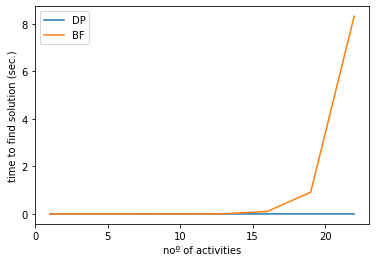

In [25]:
import matplotlib.pyplot as plt

plt.plot(n, DP_times)
plt.plot(n, BF_times)
plt.xlabel("noº of activities")
plt.ylabel("time to find solution (sec.)")
plt.legend(('DP', 'BF'))
plt.show()

# Computational Critique

A strength of this algorithm is its obvious superiority both in run time and space complexity compared to a brute force approach. It is much more efficient on both metrics.

A weakness of the DP approach is that it can only identify one unique solution in terms of the schedule outputs. That is, if slightly adjusted, the brute force algorithm would be able to output every combination that leads to the optimal output if there are for example two optimal combinations. The dynamic approach of tracing back from the top right corner reconstructs the best schedule backwards which means that the schedule outputted is input dependent if there are two different schedules that are possible. This is why in my brute force vs. dynammic programming check above, we had to compare simply the profits not the actual schedule. The chance of multiple schedules being optimal increases with the number of unique profits and lengths of activities. 

The weakness of unit dependency is described in the complexity analysis. This dependency, however, also has direct implications on the practical inputs that are allowed in the scheduler because the length of an activity has to be a whole number as the numpy array used to memoize the schedule cannot have "partially filled" cells. 